In [17]:
from pulp import *
from fractions import Fraction
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import binom

In [2]:
class Node:
    def __init__(self, value, depth, parent=None):
        self.value = value
        self.depth = depth
        self.lp_variable = LpVariable(name=f"p{depth}_{value}", lowBound=0, upBound=1)
        self.left = None
        self.right = None
        self.parent = parent
    
    def get_left_child(self):
        return self.left
    
    def get_right_child(self):
        return self.right
    
    def get_parent(self):
        return self.parent
    
            
    def print_tree(self, prefix="", is_left=True, fraction=True):
        if self.right is not None:
            new_prefix = prefix + ("│           " if is_left else "            ")
            self.right.print_tree(new_prefix, False, fraction)
        value_to_print = "" 
        if self.lp_variable.value() is not None:
            if fraction:
                value_to_print = f'({ Fraction(self.lp_variable.value())})'
            else:
                value_to_print = f'({ (self.lp_variable.value())})'
        print(prefix + ("└───────────── " if is_left else "┌───────────── ") + f'- {self.depth}_{self.value}' + value_to_print)
        if self.left is not None:
            new_prefix = prefix + ("            " if is_left else "│           ")
            self.left.print_tree(new_prefix, True, fraction)
        
            

def generate_full_binary_tree(depth, current_depth=0, parent=None, value=1):
    """Recursively generates a full binary tree to the specified depth."""
    if depth < 0 or current_depth > depth:
        return None
    
    # Create the current node
    node = Node(value, current_depth, parent)
    
    # If not at the desired depth, create left and right children
    if current_depth < depth:
        node.left = generate_full_binary_tree(depth, current_depth + 1, node, value*2)
        node.right = generate_full_binary_tree(depth, current_depth + 1, node, value*2 + 1)
    
    return node


def get_lp_expressions(node, correct_left_r, correct_right_r, expression_0=None, expression_1=None):
    if not node.left and not node.right: # Leaf node
        return [expression_0, expression_1]
    
    expression_left_0 = expression_0 + correct_left_r * (1 - node.lp_variable)
    expression_left_1 = expression_1 + correct_left_r * (-node.lp_variable)
    expressions_left = get_lp_expressions(node.left, correct_left_r, correct_right_r, expression_left_0, expression_left_1)
    
    expression_right_0 = expression_0 + correct_right_r * (node.lp_variable - 1)
    expression_right_1 = expression_1 + correct_right_r * (node.lp_variable)
    expressions_right = get_lp_expressions(node.right, correct_left_r, correct_right_r, expression_right_0, expression_right_1)
    
    #return all the results as array with 1 dimension
    return expressions_left + expressions_right
    
    

def get_lp_constraints(expressions, c):
    constraints_dict = {}
        
    for expression in expressions:
        # Separate the LHS and RHS of the expression
        lhs_expression = expression - expression.constant
        rhs_value = -expression.constant  # Assuming expression is <= 0
        
        lhs_str = str(lhs_expression)  # Use LHS for comparison
        
        # Check if this LHS is already in the dictionary
        if lhs_str in constraints_dict:
            # Keep the most restrictive constraint (smaller RHS value)
            existing_rhs_value = -constraints_dict[lhs_str].constant
            if rhs_value < existing_rhs_value:
                constraints_dict[lhs_str] = lhs_expression - c <= rhs_value
        else:
            constraints_dict[lhs_str] = lhs_expression - c <= rhs_value
    
    # Return the list of unique, most restrictive constraints
    return list(constraints_dict.values())
    
    
T = 9 # Depth of the tree
root = generate_full_binary_tree(T)
c = LpVariable(name="c")
model2 = LpProblem(name="experts-problem-1", sense=LpMinimize)
expressions = get_lp_expressions(root, correct_left_r=1, correct_right_r=1,  expression_0=LpAffineExpression(), expression_1=LpAffineExpression())
constraints = get_lp_constraints(expressions, c) 
model2 += c
for constraint in constraints:
    model2 += constraint
model2.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/hadar/Dev/RL/.venv/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/69479c3ac161477e8db2fca8911c55a2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/69479c3ac161477e8db2fca8911c55a2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 517 COLUMNS
At line 5639 RHS
At line 6152 BOUNDS
At line 6665 ENDATA
Problem MODEL has 512 rows, 512 columns and 5120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 512 (0) rows, 512 (0) columns and 5120 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0 ( 0%) - largest zero change 9.9573314e-05
0  Obj 0 Primal inf 629.99997 (256) Dual inf 0.0099999 (1) w.o. free dual inf (0)
85  Obj 0.74019256 Primal inf 345.74998 (161)
170  Obj 1

1

In [3]:
print(f"Optimal value of c: {c.value()}")

Optimal value of c: 1.2304688


In [4]:
root.print_tree()

│                                                                                                           ┌───────────── - 9_1023
│                                                                                               ┌───────────── - 8_511(0)
│                                                                                               │           └───────────── - 9_1022
│                                                                                   ┌───────────── - 7_255(0)
│                                                                                   │           │           ┌───────────── - 9_1021
│                                                                                   │           └───────────── - 8_510(0)
│                                                                                   │                       └───────────── - 9_1020
│                                                                       ┌───────────── - 6_127(0)
│                   

New model - if e1 was right he receives 1 coin, if e2 was right he receives 2 coins

In [ ]:
def get_root_model_matrix(T, correct_left_r, correct_right_r):
    root = generate_full_binary_tree(T)
    c = LpVariable(name="c")
    model = LpProblem(sense=LpMinimize)
    expressions = get_lp_expressions(root, correct_left_r, correct_right_r, LpAffineExpression(), LpAffineExpression())
    constraints = get_lp_constraints(expressions, c) 
    model += c
    for constraint in constraints:
        model += constraint
    model.solve(PULP_CBC_CMD(msg=False))
    print(f"Optimal value of c: {c.value()}")
    mat = get_values_matrix(root, T, correct_left_r + correct_right_r)
    return root, model, mat


def print_matrix(matrix):
    # Determine the maximum width of the elements in each column for proper alignment
    col_widths = []
    for col_idx in range(len(matrix[0])):
        max_width = max(
            len(str(matrix[row_idx][col_idx])) if matrix[row_idx][col_idx] is not None else 0
            for row_idx in range(len(matrix))
        )
        col_widths.append(max_width)

    # Header for the columns
    row_index_max_length = len(str(len(matrix) - 1))
    
    # Prepare the header row with less initial spacing
    header_row = " " * (row_index_max_length + 1) + "| " + " | ".join(f"{str(i).rjust(col_widths[i])}" for i in range(len(matrix[0])))
    print(header_row)
    
    print("-" * len(header_row))  # Separator

    # Print the matrix row by row, aligning each element according to the maximum column width
    for row_idx, row in enumerate(matrix):
        row_str = f"{str(row_idx).ljust(len(str(len(matrix) - 1)), ' ')} | " + " | ".join(
            f"{str(item).rjust(col_widths[col_idx])}" if item is not None else " " * col_widths[col_idx]
            for col_idx, item in enumerate(row)
        )
        print(row_str)

def create_fraction_with_specific_denominator(value, denominator):
    """
    Create a fraction representation from a value with a specific denominator.
    This function does not reduce the fraction.
    """
    # Convert value to a fraction
    fraction = Fraction(value)
    # Calculate the numerator that would correspond to the specific denominator
    numerator = int(fraction.numerator * denominator / fraction.denominator)
    return f"{numerator}/{denominator}"


def dfs_fill_matrix(node, matrix, T, base_denominator, left_moves=0, right_moves=0):
    """
    DFS traversal to fill the matrix with node values based on left and right moves,
    adjusting each fraction to have a denominator of 4^(T-r-l).
    """
    if node.get_left_child() is None:
        return
    
    # Calculate the fraction with the desired denominator
    desired_denominator = base_denominator ** (T - left_moves - right_moves)
    # Convert the node's value to a fraction
    fraction_representation = create_fraction_with_specific_denominator(node.lp_variable.value(), desired_denominator)
    
    # Fill the matrix cell corresponding to the number of left and right moves
    matrix[left_moves][right_moves] = fraction_representation
    
    # Recursively visit left child with incremented left_moves
    dfs_fill_matrix(node.get_left_child(), matrix, T, base_denominator, left_moves + 1, right_moves)
    
    # Recursively visit right child with incremented right_moves
    dfs_fill_matrix(node.get_right_child(), matrix, T, base_denominator, left_moves, right_moves + 1)



def get_values_matrix(root, T, base_denominator):
    """
    Create and fill a matrix based on the given tree depth T.
    """
    # Create an empty matrix of size (T+1) x (T+1)
    matrix = np.empty((T + 1, T + 1), dtype=object)
    
    # Fill the matrix using DFS
    dfs_fill_matrix(root, matrix, T, base_denominator=base_denominator)
    
    return matrix



In [14]:

root, model, mat = get_root_model_matrix(13, correct_left_r=1, correct_right_r=1)
print_matrix(mat)


Optimal value of c: 1.4663086
   |         0 |         1 |        2 |        3 |      4 |     5 |     6 |    7 |    8 |    9 |  10 |  11 |  12 | 13
---------------------------------------------------------------------------------------------------------------------
0  | 4096/8192 | 1585/4096 | 561/2048 | 176/1024 | 46/512 | 9/256 | 1/128 | 0/64 | 0/32 | 0/16 | 0/8 | 0/4 | 0/2 | 
1  | 2510/4096 | 1024/2048 | 385/1024 |  130/512 | 37/256 | 8/128 |  1/64 | 0/32 | 0/16 |  0/8 | 0/4 | 0/2 |     | 
2  | 1486/2048 |  638/1024 |  256/512 |   93/256 | 29/128 |  7/64 |  1/32 | 0/16 |  0/8 |  0/4 | 0/2 |     |     | 
3  |  848/1024 |   382/512 |  163/256 |   64/128 |  22/64 |  6/32 |  1/16 |  0/8 |  0/4 |  0/2 |     |     |     | 
4  |   466/512 |   219/256 |   99/128 |    42/64 |  16/32 |  5/16 |   1/8 |  0/4 |  0/2 |      |     |     |     | 
5  |   247/256 |   120/128 |    57/64 |    26/32 |  11/16 |   4/8 |   1/4 |  0/2 |      |      |     |     |     | 
6  |   127/128 |     63/64 |    31/32 

   |         0 |         1 |        2 |        3 |      4 |     5 |     6 |    7 |    8 |    9 |  10 |  11 |  12 | 13
---------------------------------------------------------------------------------------------------------------------
0  | 4096/8192 | 1585/4096 | 561/2048 | 176/1024 | 46/512 | 9/256 | 1/128 | 0/64 | 0/32 | 0/16 | 0/8 | 0/4 | 0/2 | 
1  | 2510/4096 | 1024/2048 | 385/1024 |  130/512 | 37/256 | 8/128 |  1/64 | 0/32 | 0/16 |  0/8 | 0/4 | 0/2 |     | 
2  | 1486/2048 |  638/1024 |  256/512 |   93/256 | 29/128 |  7/64 |  1/32 | 0/16 |  0/8 |  0/4 | 0/2 |     |     | 
3  |  848/1024 |   382/512 |  163/256 |   64/128 |  22/64 |  6/32 |  1/16 |  0/8 |  0/4 |  0/2 |     |     |     | 
4  |   466/512 |   219/256 |   99/128 |    42/64 |  16/32 |  5/16 |   1/8 |  0/4 |  0/2 |      |     |     |     | 
5  |   247/256 |   120/128 |    57/64 |    26/32 |  11/16 |   4/8 |   1/4 |  0/2 |      |      |     |     |     | 
6  |   127/128 |     63/64 |    31/32 |    15/16 |    7/8 |   3/4 | 

In [7]:
correct_left_r = 1
correct_right_r = 3
for i in range(0, 4):
    T = 1 + i * (correct_left_r + correct_right_r)
    print(f"******   T = {T} , correct_left_r = {correct_left_r}, correct_right_r = {correct_right_r}  ******")
    root_3, model_3, mat_3 = get_root_model_matrix(T=T, correct_left_r=correct_left_r, correct_right_r=correct_right_r)
    print("")
    print_matrix(mat_3)
    print("\n\n")

******   T = 1 , correct_left_r = 1, correct_right_r = 3  ******
Optimal value of c: 0.75

  |   0 | 1
-----------
0 | 1/4 | 
1 |     | 



******   T = 5 , correct_left_r = 1, correct_right_r = 3  ******
Optimal value of c: 1.5820312

  |        0 |      1 |    2 |    3 |   4 | 5
---------------------------------------------
0 | 432/1024 | 27/256 | 0/64 | 0/16 | 0/4 | 
1 |  135/256 |   9/64 | 0/16 |  0/4 |     | 
2 |    42/64 |   3/16 |  0/4 |      |     | 
3 |    13/16 |    1/4 |      |      |     | 
4 |      4/4 |        |      |      |     | 
5 |          |        |      |      |     | 



******   T = 9 , correct_left_r = 1, correct_right_r = 3  ******
Optimal value of c: 2.1023712

  |             0 |           1 |         2 |      3 |      4 |     5 |    6 |    7 |   8 | 9
---------------------------------------------------------------------------------------------
0 | 116640/262144 | 13851/65536 | 729/16384 | 0/4096 | 0/1024 | 0/256 | 0/64 | 0/16 | 0/4 | 
1 |   34263/65536 |  4

In [8]:
correct_left_r = 2
correct_right_r = 5
for i in range(2, 3):
    T = 1 + i * (correct_left_r + correct_right_r)
    print(f"******   T = {T} , correct_left_r = {correct_left_r}, correct_right_r = {correct_right_r}  ******")
    root_3, model_3, mat_3 = get_root_model_matrix(T=T, correct_left_r=correct_left_r, correct_right_r=correct_right_r)
    print("")
    print_matrix(mat_3)
    print("\n\n")

******   T = 15 , correct_left_r = 2, correct_right_r = 5  ******
Optimal value of c: 4.9416816

   |                           0 |                         1 |                       2 |                     3 |                   4 |           5 |          6 |         7 |        8 |        9 |      10 |     11 |    12 |   13 |  14 | 15
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | 2212177749124/4747561509943 | 204306643405/678223072849 | 15068359112/96889010407 | 771484378/13841287201 | 19531249/1977326743 | 0/282475249 | 0/40353607 | 0/5764801 | 0/823543 | 0/117649 | 0/16807 | 0/2401 | 0/343 | 0/49 | 0/7 | 
1  |   360712893819/678223072849 |   34833984648/96889010407 |  2705078192/13841287201 |  146484375/1977326743 |   3906249/282475249 |  0/40353607 |  0/5764801 |  0/823543 | 0/117649 |  0/

In [9]:
(5 * 58208984516 + 2 * 34833984648 - 360712893819 ) / 678223072849

-2.8648391329980465e-09

In [10]:
correct_left_r = 3
correct_right_r = 4
for i in range(1, 2):
    T = 1 + i * (correct_left_r + correct_right_r)
    print(f"******   T = {T} , correct_left_r = {correct_left_r}, correct_right_r = {correct_right_r}  ******")
    root_3, model_3, mat_3 = get_root_model_matrix(T=T, correct_left_r=correct_left_r, correct_right_r=correct_right_r)
    print("")
    print_matrix(mat_3)
    print("\n\n")

******   T = 8 , correct_left_r = 3, correct_right_r = 4  ******
Optimal value of c: 4.0286421

  |               0 |             1 |            2 |         3 |      4 |     5 |    6 |   7 | 8
------------------------------------------------------------------------------------------------
0 | 2797311/5764801 | 261376/823543 | 18688/117649 | 767/16807 | 0/2401 | 0/343 | 0/49 | 0/7 | 
1 |   503296/823543 |  51327/117649 |   4096/16807 |  192/2401 |  0/343 |  0/49 |  0/7 |     | 
2 |    87327/117649 |    9760/16807 |     879/2401 |    47/343 |   0/49 |   0/7 |      |     | 
3 |     14511/16807 |     1780/2401 |      184/343 |     12/49 |    0/7 |       |      |     | 
4 |       2292/2401 |       306/343 |        36/49 |       3/7 |        |       |      |     | 
5 |         343/343 |         49/49 |          7/7 |           |        |       |      |     | 
6 |           49/49 |           7/7 |              |           |        |       |      |     | 
7 |             7/7 |               | 

In [11]:
correct_left_r = 3
correct_right_r = 1
for i in range(1, 2):
    T = 1 + i * (correct_left_r + correct_right_r)
    print(f"******   T = {T} , correct_left_r = {correct_left_r}, correct_right_r = {correct_right_r}  ******")
    root_3, model_3, mat_3 = get_root_model_matrix(T=T, correct_left_r=correct_left_r, correct_right_r=correct_right_r)
    print("")
    print_matrix(mat_3)
    print("\n\n")

******   T = 5 , correct_left_r = 3, correct_right_r = 1  ******
Optimal value of c: 1.5820312

  |        0 |       1 |     2 |    3 |   4 | 5
-----------------------------------------------
0 | 592/1024 | 121/256 | 22/64 | 3/16 | 0/4 | 
1 |  229/256 |   55/64 | 13/16 |  3/4 |     | 
2 |    64/64 |   16/16 |   4/4 |      |     | 
3 |    16/16 |     4/4 |       |      |     | 
4 |      4/4 |         |       |      |     | 
5 |          |         |       |      |     | 


In [12]:
correct_left_r = 1
correct_right_r = 8
for i in range(0, 3):
    T = 1 + i * (correct_left_r + correct_right_r)
    print(f"******   T = {T} , correct_left_r = {correct_left_r}, correct_right_r = {correct_right_r}  ******")
    root_3, model_3, mat_3 = get_root_model_matrix(T=T, correct_left_r=correct_left_r, correct_right_r=correct_right_r)
    print("")
    print_matrix(mat_3)
    print("\n\n")

******   T = 1 , correct_left_r = 1, correct_right_r = 8  ******
Optimal value of c: 0.88888889

  |   0 | 1
-----------
0 | 0/9 | 
1 |     | 



******   T = 10 , correct_left_r = 1, correct_right_r = 8  ******
Optimal value of c: 3.4643942

   |                     0 |                  1 |          2 |         3 |        4 |       5 |      6 |     7 |    8 |   9 | 10
--------------------------------------------------------------------------------------------------------------------------------
0  | 1358954485/3486784401 | 16777215/387420489 | 0/43046721 | 0/4782969 | 0/531441 | 0/59049 | 0/6561 | 0/729 | 0/81 | 0/9 | 
1  |   167772159/387420489 |   2097152/43046721 |  0/4782969 |  0/531441 |  0/59049 |  0/6561 |  0/729 |  0/81 |  0/9 |     | 
2  |     20709375/43046721 |     262143/4782969 |   0/531441 |   0/59049 |   0/6561 |   0/729 |   0/81 |   0/9 |      |     | 
3  |       2555903/4782969 |       32767/531441 |    0/59049 |    0/6561 |    0/729 |    0/81 |    0/9 |       |      

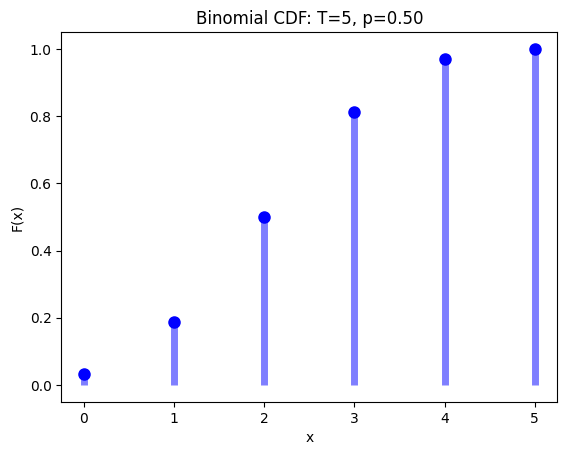

In [18]:

# create a binomial distribution cdf and pdf and plot them
T = 5
p = 0.5
x = np.arange(0, T+1)
y = binom.cdf(x, T, p)

plt.plot(x, y, 'bo', ms=8)
plt.vlines(x, 0, y, colors='b', lw=5, alpha=0.5)
plt.title('Binomial CDF: T=%i, p=%.2f' % (T, p))
plt.xlabel('x')
plt.ylabel('F(x)')
plt.show()

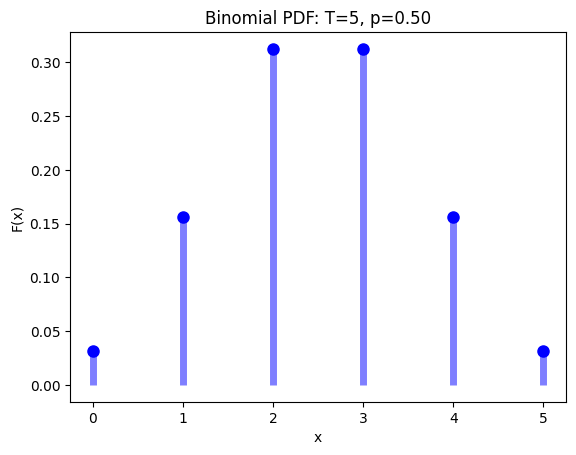

In [20]:
pdf = binom.pmf(x, T, p)
plt.plot(x, pdf, 'bo', ms=8)
plt.vlines(x, 0, pdf, colors='b', lw=5, alpha=0.5)
plt.title('Binomial PDF: T=%i, p=%.2f' % (T, p))
plt.xlabel('x')
plt.ylabel('F(x)')
plt.show()


In [83]:
def get_binomial_matrix(T, left_r, right_r):
    w = math.floor(T * left_r / (left_r + right_r))
    y = np.ndarray((T+1, T+1)).astype(str)    
    p = float(left_r / (left_r + right_r))
    base_denominator = left_r + right_r
    for i in range(T+1):
        for j in range(T+1):
            try:
                fraction = Fraction(1 - binom.cdf(w-i, T-j-i, p))
                desired_denominator = base_denominator ** (T - i - j)
                fraction = create_fraction_with_specific_denominator(fraction, desired_denominator)
            except Exception as e:
                # print(e)
                fraction = ""
            y[i, j] = fraction
    return y


T = 20 # number of trials
p = Fraction(1,2) # probability of success
mat = get_binomial_matrix(T, left_r=1, right_r=1)
print_matrix(mat)



   |              0 |             1 |            2 |            3 |          4 |          5 |         6 |       7 |       8 |      9 |     10 |    11 |    12 |    13 |   14 |   15 |   16 |  17 |  18 |  19 |  20
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | 431910/1048576 | 169766/524288 | 63004/262144 | 21778/131072 | 6885/65536 | 1941/32768 | 470/16384 | 92/8192 | 13/4096 | 1/2048 | 0/1024 | 0/512 | 0/256 | 0/128 | 0/64 | 0/32 | 0/16 | 0/8 | 0/4 | 0/2 | 0/1
1  |  262144/524288 | 106762/262144 | 41226/131072 |  14893/65536 | 4944/32768 | 1471/16384 |  378/8192 | 79/4096 | 12/2048 | 1/1024 |  0/512 | 0/256 | 0/128 |  0/64 | 0/32 | 0/16 |  0/8 | 0/4 | 0/2 | 0/1 |    
2  |  155382/262144 |  65536/131072 |  26333/65536 |   9949/32768 | 3473/16384 |  1093/8192 |  299/4096 | 67/2048 | 11/1024 |  1/512 |  0/256 | 0/128 |  0/6

In [68]:
T = 5
mat = get_binomial_matrix(T, left_r=1, right_r=3)
print_matrix(mat)

  |        0 |      1 | 2 | 3 | 4 | 5
-------------------------------------
0 | 376/1024 | 16/256 |  |  |  | 
1 |  175/256 |  16/64 |  |  |  | 
2 |    64/64 |  16/16 |  |  |  | 
3 |    16/16 |        |  |  |  | 
4 |      4/4 |        |  |  |  | 
5 |      1/1 |        |  |  |  | 


/var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/ipykernel_72324/1287175830.py:32: RuntimeWarning: divide by zero encountered in divide
  plt.plot(T_values, sqrt_T_values/regret_values, label='sqrt(T)/Regret(T)', linestyle='--')


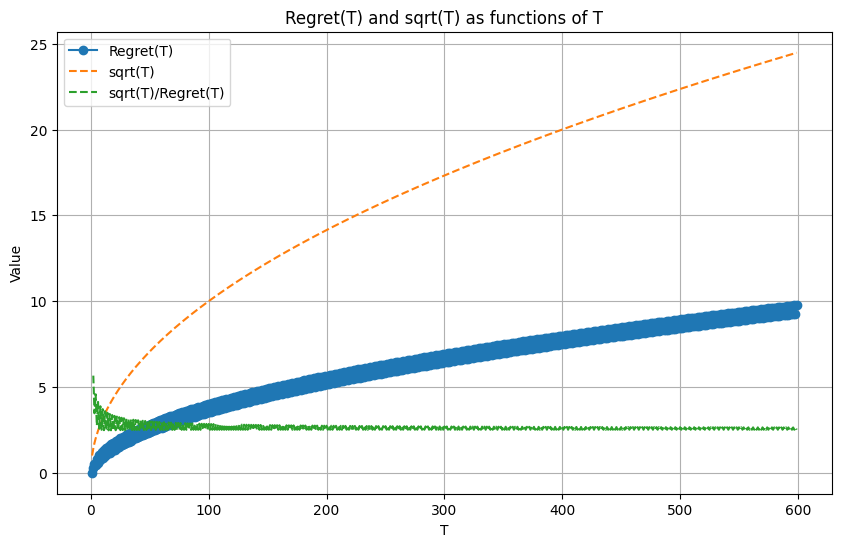

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
import math

# Define the function to calculate regret
def calc_regret(T):
    w = math.floor(T / 2)
    p = 0.5
    regret = 0
    for j in range(w):
        regret += (1 - binom.cdf(w, T-j, p))
    return regret

# Generate values for T from 1 to 30
T_values = np.arange(1, 600)

# Calculate regret and sqrt(T) for each T
regret_values = [calc_regret(T) for T in T_values]
sqrt_T_values = np.sqrt(T_values)

#create new arr of the regret values - (0.4 * sqrt(T))
# sqrt_T_fact = [0.4 * sqrt_T for sqrt_T in sqrt_T_values]




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(T_values, regret_values, label='Regret(T)', marker='o')
plt.plot(T_values, sqrt_T_values, label='sqrt(T)', linestyle='--')
plt.plot(T_values, sqrt_T_values/regret_values, label='sqrt(T)/Regret(T)', linestyle='--')
# plt.plot(T_values, regret_values- sqrt_T_fact, label='Regret(T) - 0.4*sqrt(T)', linestyle='--')
plt.title('Regret(T) and sqrt(T) as functions of T')
plt.xlabel('T')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
sqrt_T_values[-1] / regret_values[-1]

2.505582321334883

******   T = 5 , correct_left_r = 1, correct_right_r = 3  ******
Optimal value of c: 1.5820312

  |        0 |      1 |    2 |    3 |   4 | 5
---------------------------------------------
0 | 432/1024 | 27/256 | 0/64 | 0/16 | 0/4 | 
1 |  135/256 |   9/64 | 0/16 |  0/4 |     | 
2 |    42/64 |   3/16 |  0/4 |      |     | 
3 |    13/16 |    1/4 |      |      |     | 
4 |      4/4 |        |      |      |     | 
5 |          |        |      |      |     | 